# Comparison of GRCWA NLOPT Optimisation with NIDN Siren and NIDN Voxel.

In the following we compare an optimisation using GRCWA with NIDN using a Siren network and NIDN when directly encoding permittivity as a voxel grid.

The test case is the design of a material that is maximally reflective.

1. GRCWA - Optimisation as described here https://github.com/weiliangjinca/grcwa/blob/master/example/ex3.py
2. NIDN Siren - As in other notebooks
3. NIDN Voxel - Weights are directly permittivities of the material.

Let's start with imports

In [2]:
### Imports
%load_ext autoreload
%autoreload 2

# Append main folder
import sys
sys.path.append("../..")

import nidn
import nlopt
import grcwa
grcwa.set_backend('autograd')
import torch
import numpy as npf
import autograd.numpy as np
from autograd import grad
import matplotlib.pyplot as plt

# Start with the default config
cfg = nidn.load_default_cfg()

10:18:16|NIDN-INFO| Initialized NIDN for cpu
10:18:16|NIDN-INFO| Using double precision
10:18:16|NIDN-INFO| Switching log level to warning.


Let's define grid specifics etc. both for GRCWA and NIDN

In [2]:
# Set grid specifics
# Change to 32 to generate grid plot with more than 1 element displayed
cfg.Nx = 1
cfg.Ny = 1
cfg.N_layers = 5
cfg.N_freq = 20
cfg.TRCWA_L_grid = [[0.1,0.0],[0.0,0.1]]
cfg.TRCWA_NG = 11
cfg.PER_LAYER_THICKNESS = [1.0]
cfg.freq_distribution = "log"

# Specify your desired range of wavelengths
cfg.physical_wavelength_range[0] = 2e-6
cfg.physical_wavelength_range[1] = 1e-5

# Determine target frequencies (in TRCWA units)
cfg.target_frequencies = nidn.compute_target_frequencies(
    cfg.physical_wavelength_range[0],
    cfg.physical_wavelength_range[1],
    cfg.N_freq,
    cfg.freq_distribution
)

# Allowed range of epsilon values
cfg.real_min_eps = 0.01
cfg.real_max_eps = 20.0
cfg.imag_min_eps = 0.0
cfg.imag_max_eps = 0.0 # We only allow real permittivity values for easy comparison with GRCWA using NLOPT

In [3]:
# Truncation order (actual number might be smaller)
nG = 11
# lattice constants
L1 = [0.1,0]
L2 = [0,0.1]
# frequency and angles

theta = 0.
phi = 0.

# now consider 3 layers: vacuum + patterned + vacuum
ep0 = 1. # dielectric for layer 1 (uniform)
epN = 1.  # dielectric for layer N (uniform)

thick0 = 1. # thickness for vacuum layer 1
thickN = 1.

# planewave excitation
planewave={'p_amp':0,'s_amp':1,'p_phase':0,'s_phase':0}


# Function to compute R,T with GRCWA
def fun_reflection(x,Qabs,freq):
    freqcmp = freq*(1+1j/2/Qabs)
    ######### setting up RCWA
    obj = grcwa.obj(nG,L1,L2,freqcmp,theta,phi,verbose=0)
    # input layer information
    obj.Add_LayerUniform(thick0,ep0)
    obj.Add_LayerUniform(thick0,x[:,:,0][0])
    obj.Add_LayerUniform(thick0,x[:,:,1][0])
    obj.Add_LayerUniform(thick0,x[:,:,2][0])
    obj.Add_LayerUniform(thick0,x[:,:,3][0])
    obj.Add_LayerUniform(thick0,x[:,:,4][0])
    obj.Add_LayerUniform(thickN,epN)
    obj.Init_Setup()

    obj.MakeExcitationPlanewave(planewave['p_amp'],planewave['p_phase'],planewave['s_amp'],planewave['s_phase'],order = 0)    
    R,T= obj.RT_Solve(normalize=1)
    return R,T

# Function to compute summed reflection, we aim to maximise this.
def fun_total_reflection(x,Qabs=1e5):
    total_R = 0
    x = x.reshape(1,1,cfg.N_layers,cfg.N_freq)
    for idx,freq in enumerate(cfg.target_frequencies):
        R,T = fun_reflection(x[:,:,:,idx],1e16,freq)
        total_R += R
    return total_R


### Define optimisation problem for GRCWA with NLOPT

In [4]:

ctrl = 0
fun = lambda x: fun_total_reflection(x)
grad_fun = grad(fun)


In [5]:
def fun_nlopt(x,gradn):
    global ctrl
    gradn[:] = grad_fun(x)
    y = fun(x)
    
    print('Step = ',ctrl,', R = ',y)
    ctrl += 1
    return fun(x)

# set up NLOPT
ndof = cfg.N_layers*cfg.N_freq*cfg.Nx*cfg.Ny

# Sample randomly in 0 to 20 as for neural net range
init = cfg.real_min_eps + (cfg.real_max_eps-cfg.real_min_eps)*np.random.random(ndof)
lb=np.ones(ndof,dtype=float)*0.01
ub=np.ones(ndof,dtype=float)*20.0

opt = nlopt.opt(nlopt.LD_MMA, ndof)
opt.set_lower_bounds(lb)
opt.set_upper_bounds(ub)

opt.set_xtol_rel(1e-16)
opt.set_maxeval(2000)

opt.set_max_objective(fun_nlopt)
x = opt.optimize(init)

Step =  0 , R =  11.002642731477913
Step =  1 , R =  13.928737603227802
Step =  2 , R =  16.749229624398076
Step =  3 , R =  17.575642821892767
Step =  4 , R =  17.787327008801405
Step =  5 , R =  17.829200967900206
Step =  6 , R =  17.967813442778205
Step =  7 , R =  16.885157347476472
Step =  8 , R =  17.15260980695369
Step =  9 , R =  18.01994632982744
Step =  10 , R =  18.15600294616038
Step =  11 , R =  16.033088977843185
Step =  12 , R =  17.842738084989627
Step =  13 , R =  18.187132134616682
Step =  14 , R =  18.194951053064333
Step =  15 , R =  17.292587239915257
Step =  16 , R =  17.810241854047952
Step =  17 , R =  18.336988784588705
Step =  18 , R =  18.341662630539673
Step =  19 , R =  18.363992079533986
Step =  20 , R =  18.04135922987203
Step =  21 , R =  18.391228095825966
Step =  22 , R =  18.449187356847958
Step =  23 , R =  18.20521113429569
Step =  24 , R =  18.461150681375123
Step =  25 , R =  18.429823934934568
Step =  26 , R =  18.467567089047414
Step =  27 , R =

### Plot achieved spectrum

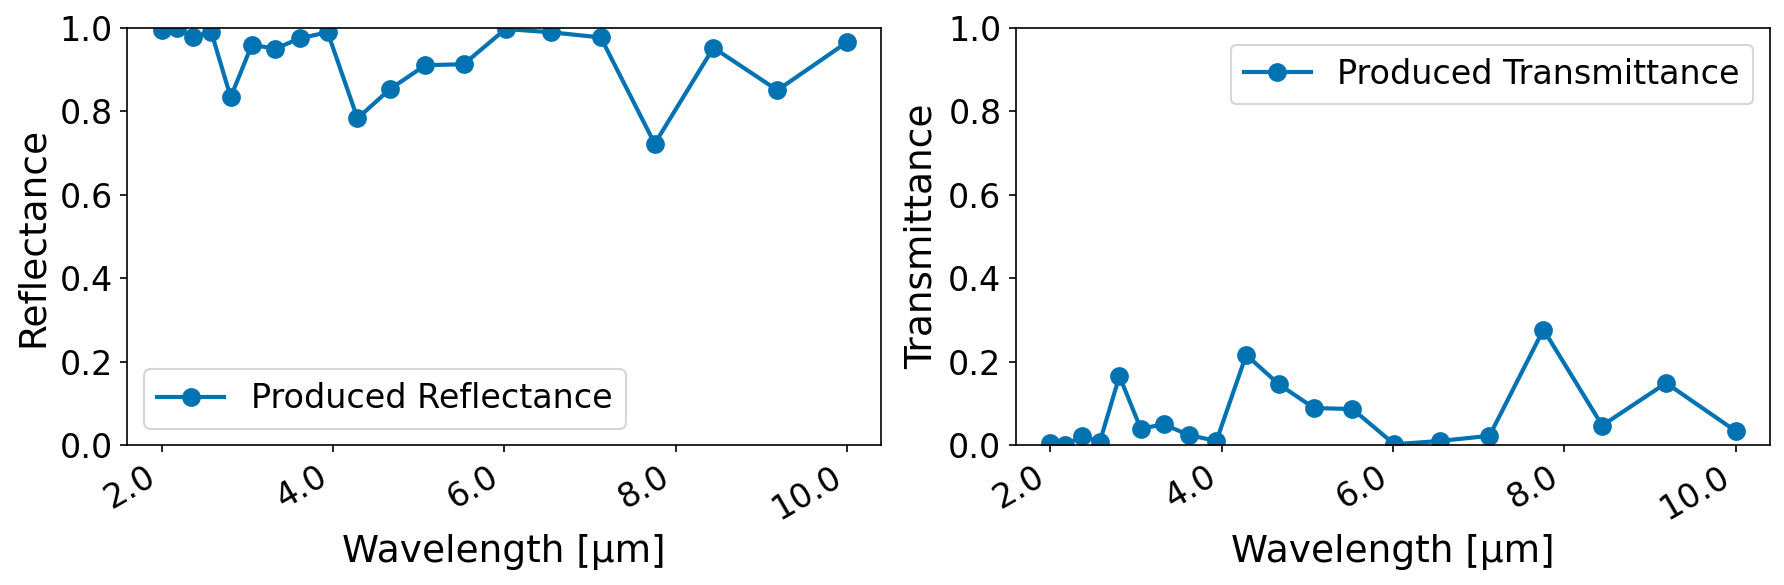

In [6]:
x = x.reshape(1,1,cfg.N_layers,cfg.N_freq)
np.save("eps_nlopt.np",x)
Rs,Ts = [],[]
for idx,freq in enumerate(cfg.target_frequencies):
    R,T = fun_reflection(x[:,:,:,idx],1e16,freq)
    Rs.append(R)
    Ts.append(T)

nidn.plot_spectrum(cfg,Rs,Ts)

### Set up VoxelGrid optimisation with NIDN

In [7]:
cfg.pop("model",None); # Forget the old model

cfg.model_type = "voxel"
cfg.learning_rate = 5e-2 # LR can be much higher here as we directly optimise the permittivity

# Define reflection only spectrum
cfg.target_reflectance_spectrum = [1]*cfg.N_freq
cfg.target_transmittance_spectrum = [0]*cfg.N_freq

cfg.type = "regression" # Choose type as described above
cfg.iterations = 2000 # Set number of training iterations (that is forward model evaluations) to perform
nidn.set_log_level("INFO")

In [8]:
nidn.run_training(cfg);

19:05:08|NIDN-INFO| ###  New Best=0.4653 with SpectrumLoss=0.4653 ### L1=0.4653
19:05:08|NIDN-INFO| It=0     Loss=0.4653   |  weighted_avg=0.4653  |  SpectrumLoss=0.4653 | L1=0.4653
19:05:08|NIDN-INFO| ###  New Best=0.4323 with SpectrumLoss=0.4323 ### L1=0.4323
19:05:08|NIDN-INFO| ###  New Best=0.4029 with SpectrumLoss=0.4029 ### L1=0.4029
19:05:09|NIDN-INFO| ###  New Best=0.3758 with SpectrumLoss=0.3758 ### L1=0.3758
19:05:09|NIDN-INFO| ###  New Best=0.3515 with SpectrumLoss=0.3515 ### L1=0.3515
19:05:09|NIDN-INFO| ###  New Best=0.3300 with SpectrumLoss=0.3300 ### L1=0.3300
19:05:09|NIDN-INFO| It=5     Loss=0.3300   |  weighted_avg=0.3930  |  SpectrumLoss=0.3300 | L1=0.3300
19:05:10|NIDN-INFO| ###  New Best=0.3111 with SpectrumLoss=0.3111 ### L1=0.3111
19:05:10|NIDN-INFO| ###  New Best=0.2945 with SpectrumLoss=0.2945 ### L1=0.2945
19:05:10|NIDN-INFO| ###  New Best=0.2804 with SpectrumLoss=0.2804 ### L1=0.2804
19:05:10|NIDN-INFO| ###  New Best=0.2681 with SpectrumLoss=0.2681 ### L1=0.2

Epoch  1924: reducing learning rate of group 0 to 3.3000e-02.


19:15:49|NIDN-INFO| ###  New Best=0.0499 with SpectrumLoss=0.0499 ### L1=0.0499
19:15:49|NIDN-INFO| It=1925  Loss=0.0499   |  weighted_avg=0.0499  |  SpectrumLoss=0.0499 | L1=0.0499
19:15:50|NIDN-INFO| ###  New Best=0.0499 with SpectrumLoss=0.0499 ### L1=0.0499
19:15:50|NIDN-INFO| ###  New Best=0.0499 with SpectrumLoss=0.0499 ### L1=0.0499
19:15:50|NIDN-INFO| ###  New Best=0.0499 with SpectrumLoss=0.0499 ### L1=0.0499
19:15:51|NIDN-INFO| ###  New Best=0.0499 with SpectrumLoss=0.0499 ### L1=0.0499
19:15:51|NIDN-INFO| ###  New Best=0.0499 with SpectrumLoss=0.0499 ### L1=0.0499
19:15:51|NIDN-INFO| It=1930  Loss=0.0499   |  weighted_avg=0.0499  |  SpectrumLoss=0.0499 | L1=0.0499
19:15:51|NIDN-INFO| ###  New Best=0.0499 with SpectrumLoss=0.0499 ### L1=0.0499
19:15:52|NIDN-INFO| ###  New Best=0.0499 with SpectrumLoss=0.0499 ### L1=0.0499
19:15:52|NIDN-INFO| ###  New Best=0.0499 with SpectrumLoss=0.0499 ### L1=0.0499
19:15:53|NIDN-INFO| ###  New Best=0.0499 with SpectrumLoss=0.0499 ### L1=0.0

### Plot and save results

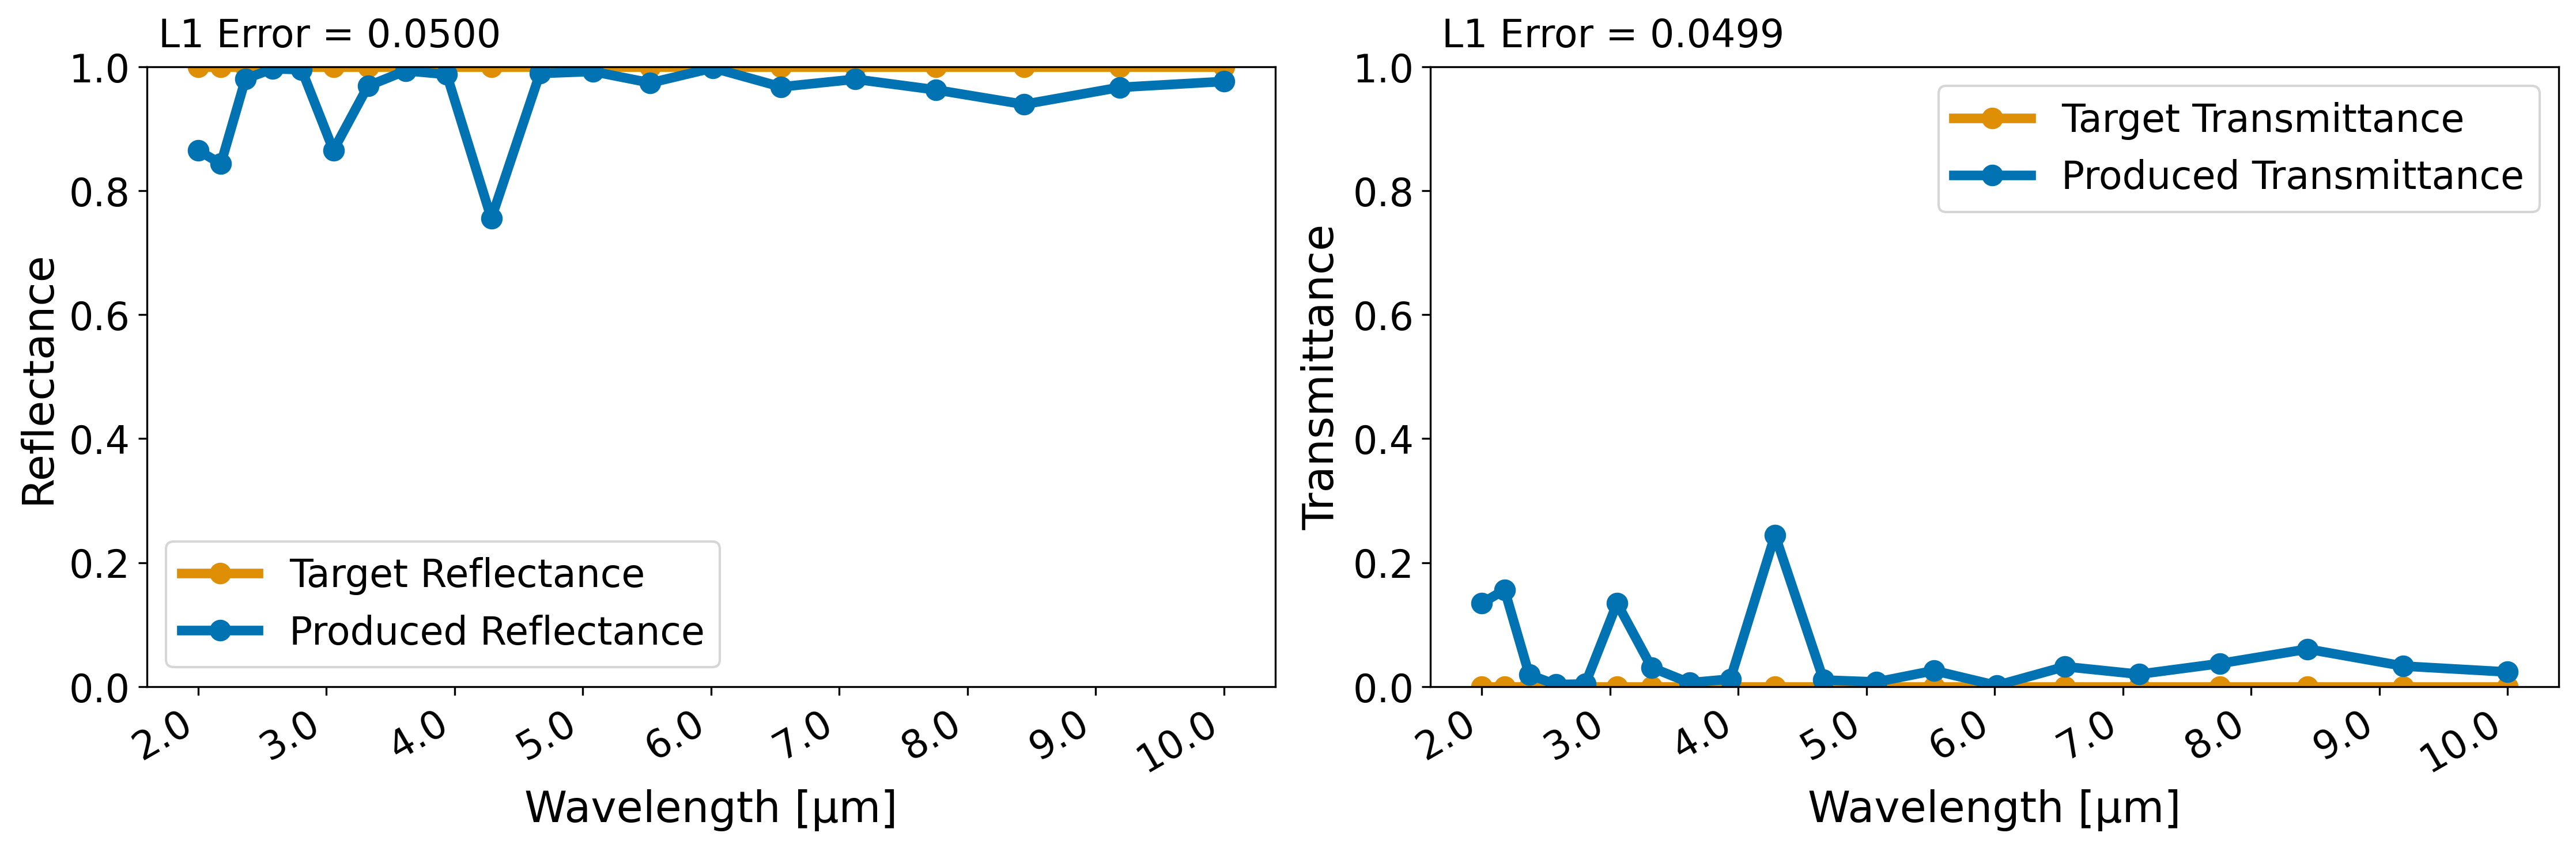

19:16:17|NIDN-INFO| Saving run to file: ../results//voxel_run_24-11-2022 19-16-17_run.pk


In [9]:
nidn.plot_spectra(cfg)
cfg.name = "voxel_run"
nidn.save_run(cfg)

### Now do the same with NIDN Siren

In [10]:
cfg.pop("model",None); # Forget the old model

cfg.model_type = "siren"
cfg.learning_rate = 8e-5

cfg.siren_omega = 1.

cfg.type = "regression" # Choose type as described above
cfg.iterations = 2000 # Set number of training iterations (that is forward model evaluations) to perform
nidn.set_log_level("INFO")

In [11]:
nidn.run_training(cfg);

19:16:18|NIDN-INFO| ###  New Best=0.5595 with SpectrumLoss=0.5595 ### L1=0.5595
19:16:18|NIDN-INFO| It=0     Loss=0.5595   |  weighted_avg=0.5595  |  SpectrumLoss=0.5595 | L1=0.5595
19:16:18|NIDN-INFO| ###  New Best=0.5388 with SpectrumLoss=0.5388 ### L1=0.5388
19:16:19|NIDN-INFO| ###  New Best=0.5109 with SpectrumLoss=0.5109 ### L1=0.5109
19:16:19|NIDN-INFO| ###  New Best=0.4908 with SpectrumLoss=0.4908 ### L1=0.4908
19:16:20|NIDN-INFO| ###  New Best=0.4405 with SpectrumLoss=0.4405 ### L1=0.4405
19:16:20|NIDN-INFO| It=5     Loss=0.4405   |  weighted_avg=0.5180  |  SpectrumLoss=0.4405 | L1=0.4405
19:16:20|NIDN-INFO| ###  New Best=0.4224 with SpectrumLoss=0.4224 ### L1=0.4224
19:16:21|NIDN-INFO| ###  New Best=0.4004 with SpectrumLoss=0.4004 ### L1=0.4004
19:16:21|NIDN-INFO| ###  New Best=0.3930 with SpectrumLoss=0.3930 ### L1=0.3930
19:16:21|NIDN-INFO| ###  New Best=0.3583 with SpectrumLoss=0.3583 ### L1=0.3583
19:16:22|NIDN-INFO| ###  New Best=0.3451 with SpectrumLoss=0.3451 ### L1=0.3

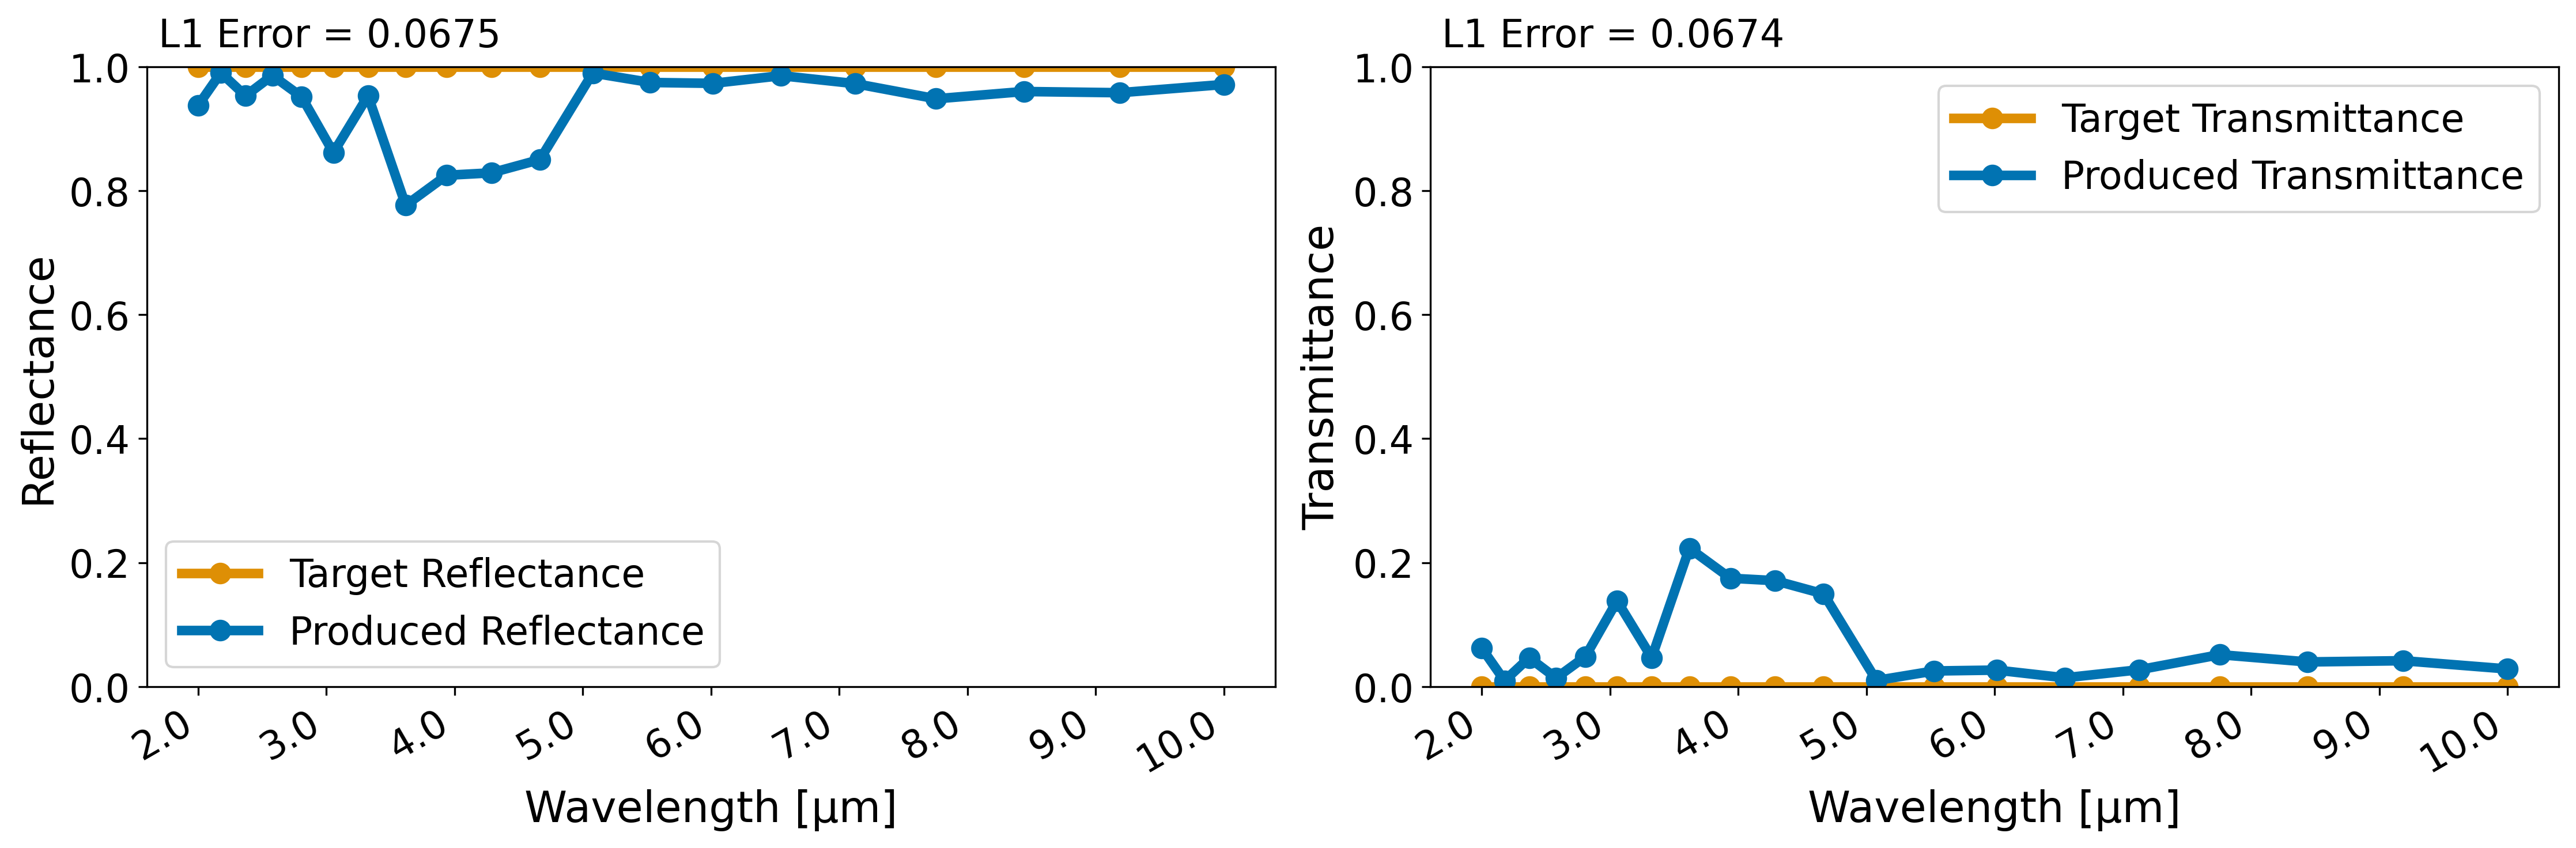

19:27:12|NIDN-INFO| Saving run to file: ../results//siren_run_24-11-2022 19-27-12_run.pk


In [12]:
nidn.plot_spectra(cfg)
cfg.name = "siren_run"
nidn.save_run(cfg)

In [16]:
voxel_cfg = nidn.load_run("../results/voxel_run_24-11-2022 19-16-17_run.pk")
voxel_loss = voxel_cfg.results.L1_errs
siren_cfg = nidn.load_run("../results/siren_run_24-11-2022 19-27-12_run.pk")
siren_loss = siren_cfg.results.L1_errs
grcwa_loss = (cfg.N_freq - np.genfromtxt("fitness_nlopt.csv")) / cfg.N_freq # convert fitness into loss

In [26]:
grcwa_loss[-1]

0.07045400615242378

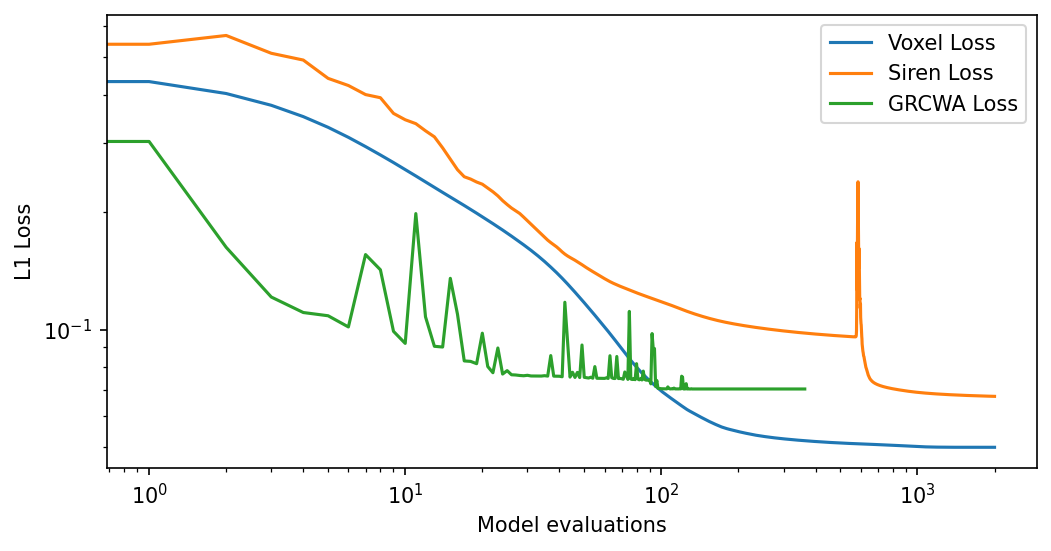

In [33]:
fig = plt.figure(figsize=(8, 4), dpi=150)
fig.patch.set_facecolor("white")
plt.plot(voxel_loss)
plt.plot(siren_loss)
plt.plot(grcwa_loss)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Model evaluations")
plt.ylabel("L1 Loss")
plt.legend(["Voxel Loss", "Siren Loss", "GRCWA Loss"])

False

In [27]:
nlopt_eps = np.load("eps_nlopt.np.npy")
eps_voxel = nidn.model_to_eps_grid(voxel_cfg.model,voxel_cfg)
eps_siren = nidn.model_to_eps_grid(siren_cfg.model,siren_cfg)

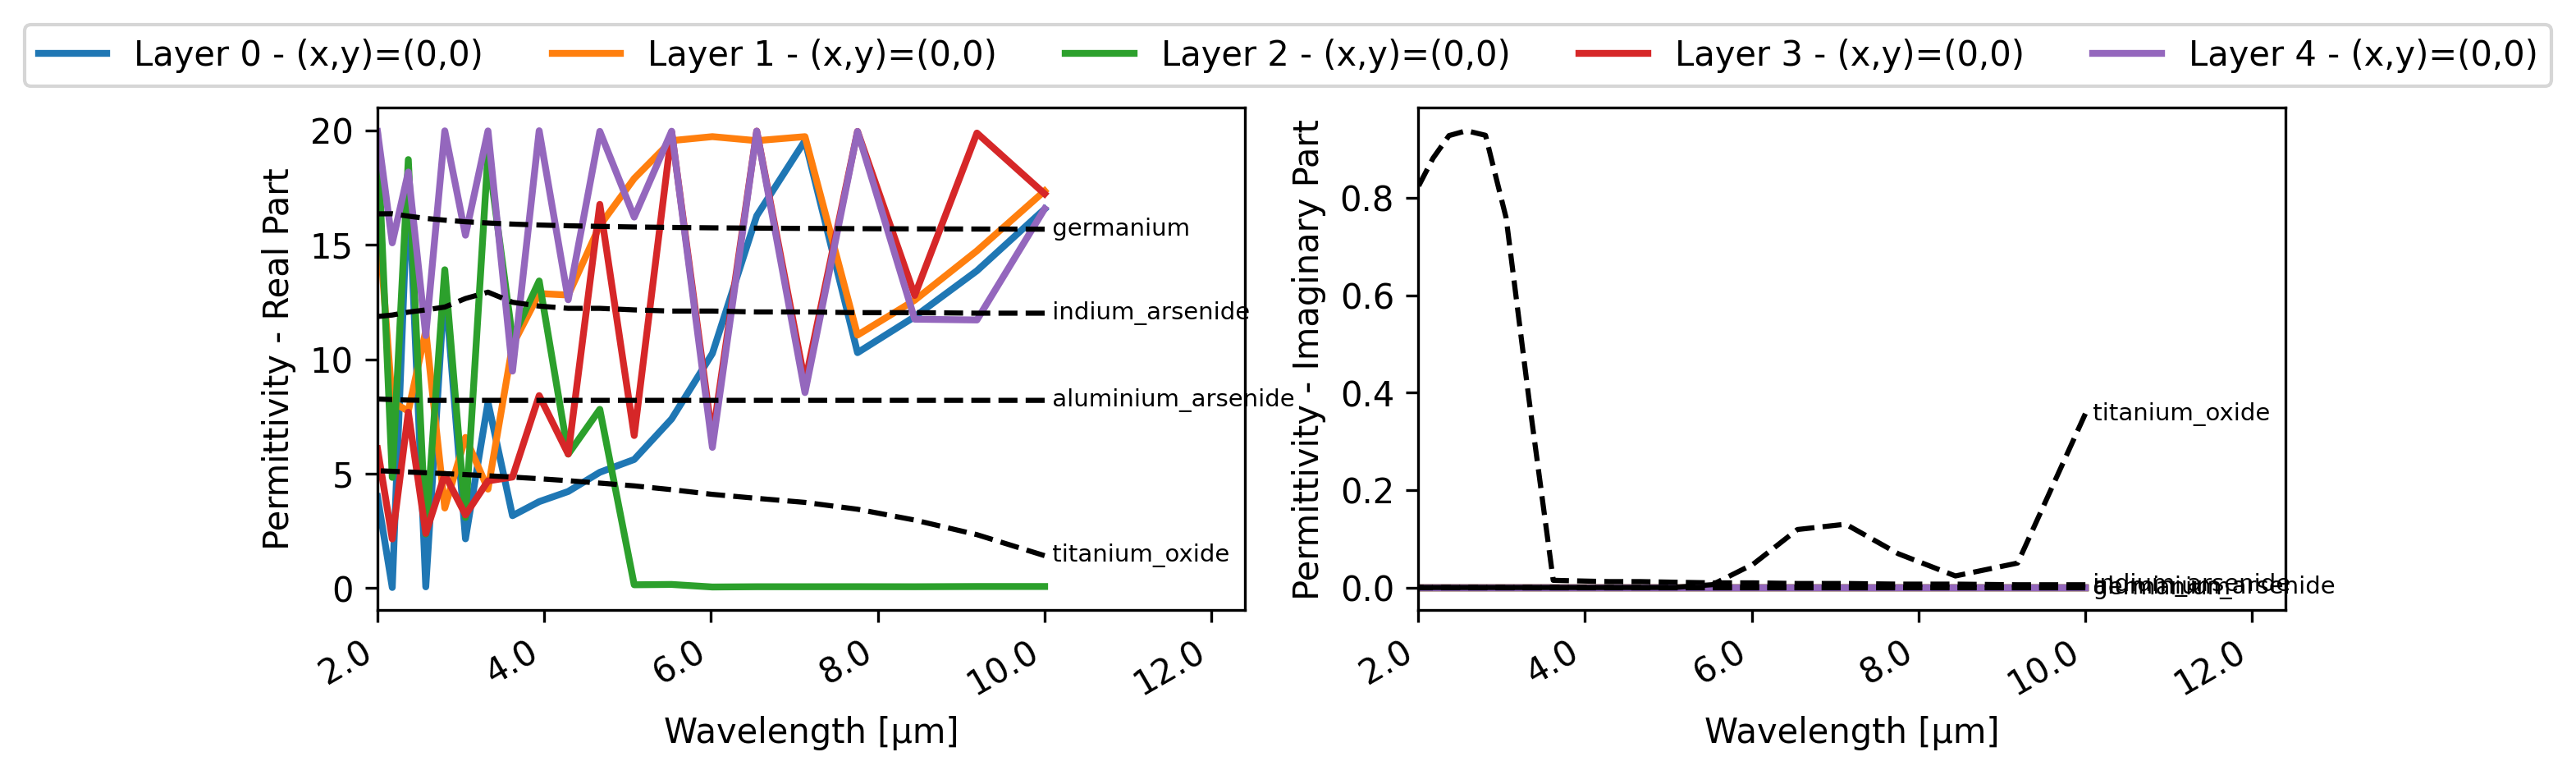

In [40]:
nidn.plot_eps_per_point(siren_cfg)

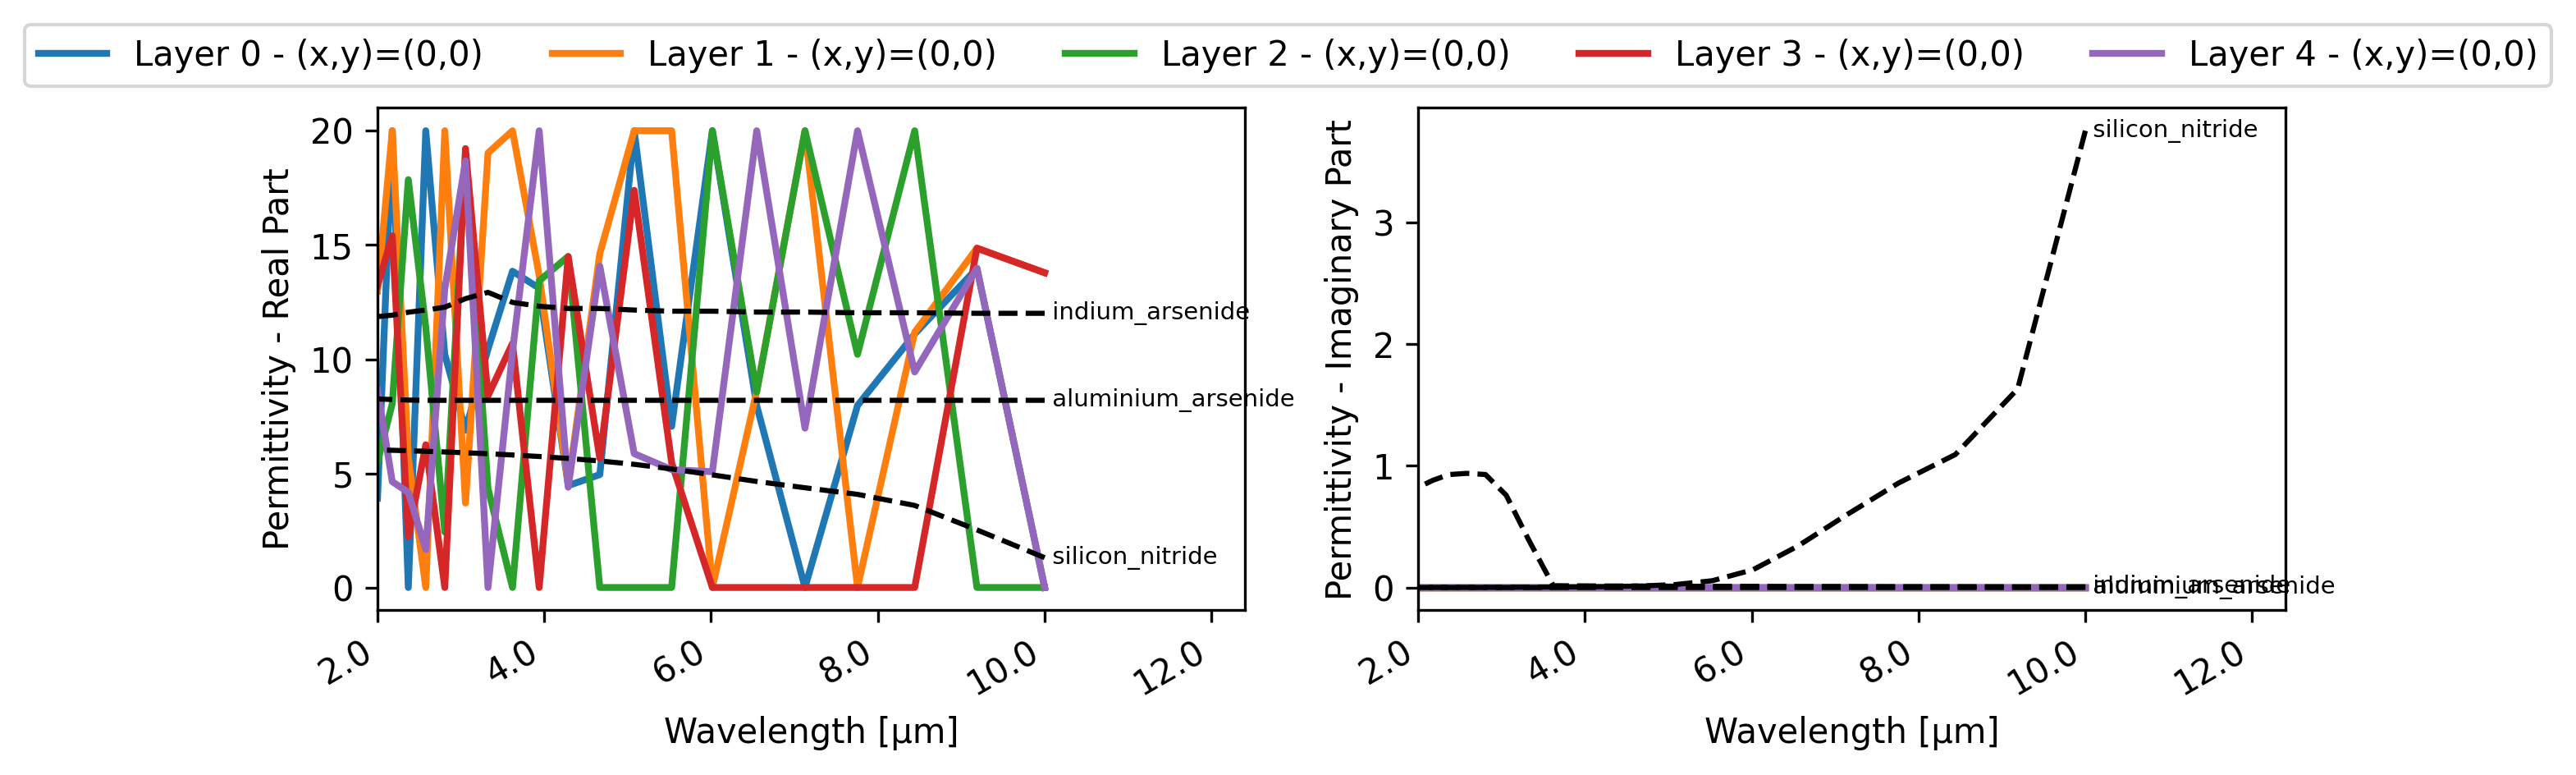

In [39]:
nidn.plot_eps_per_point(voxel_cfg)

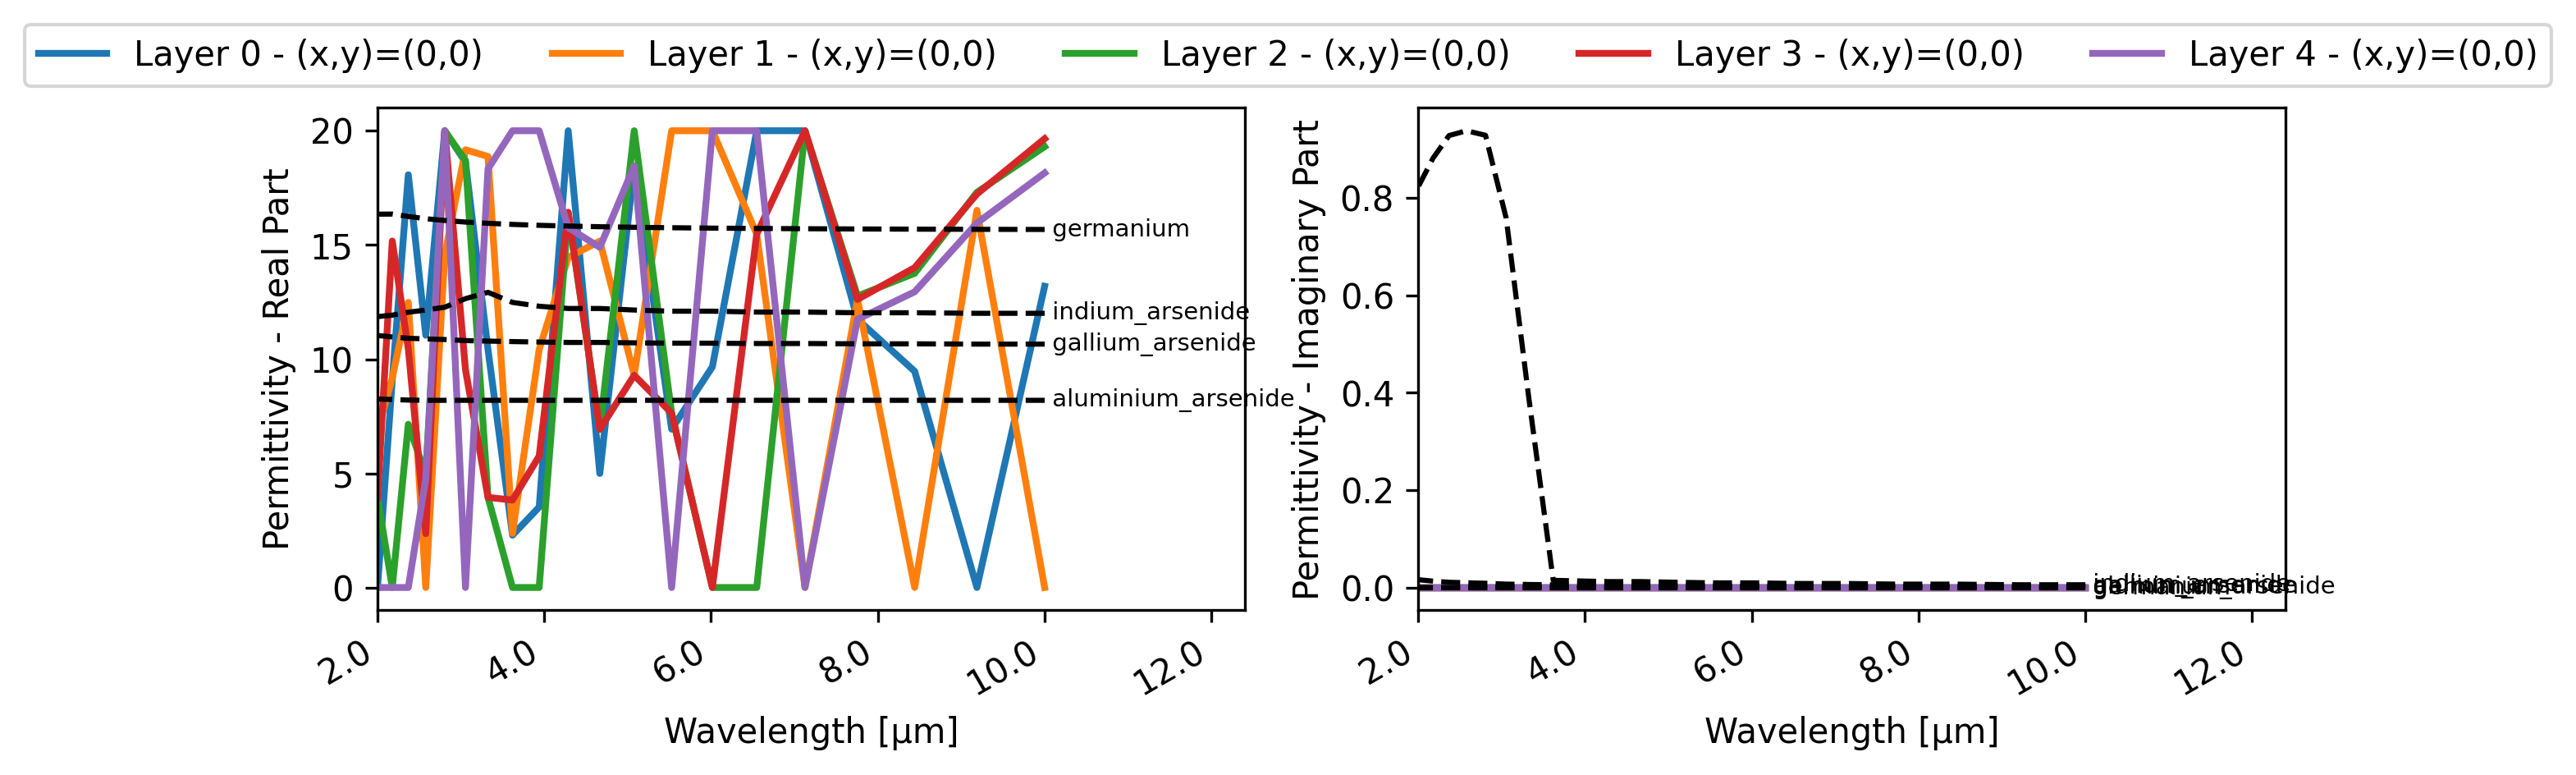

In [45]:
from copy import deepcopy
nlopt_cfg = deepcopy(voxel_cfg)
nlopt_cfg.eps = nlopt_eps
nidn.plot_eps_per_point(nlopt_cfg)